In [9]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
from skimage import morphology
import time
import math
from tqdm.notebook import tqdm
from os.path import basename

In [ ]:
train_path = './train/train_ref'
test2_path = './test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))


In [54]:
def preprocess_image(img):
    # 그레이 스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러를 사용하여 노이즈 제거
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # 이진화
    binary_image = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11,4)
    
    # 세선화
    skeleton = morphology.skeletonize(binary_image // 255).astype(np.uint8)

    return gray, binary_image, skeleton

def extract_minutiae_loop(skeleton):
    minutiae_end = []
    minutiae_bif = []

    rows, cols = skeleton.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if skeleton[i, j] == 1:
                # 3x3 윈도우 추출
                window = skeleton[i-1:i+2, j-1:j+2]
                # 중심 픽셀 제외한 8 픽셀의 합 계산
                neighbor_sum = np.sum(window) - skeleton[i, j]
                
                if neighbor_sum == 1:
                    minutiae_end.append((i, j))
                elif neighbor_sum == 3:
                    minutiae_bif.append((i, j))

    return minutiae_end, minutiae_bif

def extract_minutiae_fast(skeleton):
    # 패딩을 추가하여 경계 처리
    padded_skeleton = np.pad(skeleton, ((1, 1), (1, 1)), mode='constant')
    
    # 3x3 윈도우 추출을 위한i indexing
    indices = np.indices(skeleton.shape)
    
    # 중심 픽셀 제외한 8 픽셀의 합 계산
    neighbor_sum = np.zeros_like(skeleton)
    for i in range(3):
        for j in range(3):
            if not (i == 1 and j == 1):
                neighbor_sum += padded_skeleton[indices[0] + i, indices[1] + j]
    
    # 끝
    minutiae_end = np.argwhere((skeleton == 1) & (neighbor_sum == 1))
    # 분기 
    minutiae_bif = np.argwhere((skeleton == 1) & (neighbor_sum == 3))
    
    return minutiae_end, minutiae_bif


def match_minutiae(test_minutiae, train_minutiae):
    # test, train 지점 좌표를 numpy배열로 변환
    test_points = np.array(test_minutiae)
    train_points = np.array(train_minutiae)
    
    # 두 지점 사이의 행렬 계산 (np이용)
    distances = np.sqrt(np.sum((test_points[:, None] - train_points) ** 2, axis=2))
    
    # 최소 거리 계산
    min_distances = np.min(distances, axis=1)
    
    # 총 거리 계산
    total_distance = np.sum(min_distances)
    
    return total_distance

def get_label(file_path):
    # 파일 이름에서 숫자 부분 추출
    file_name = os.path.basename(file_path)
    label = file_name.split('.')[0][:3]  # file name의 3자리 비교를 통해 label 설정
    return label

# 매칭 결과를 기반으로 TP, TN, FP, FN 계산
def calculate_metrics(matching_results, threshold):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for result in matching_results:
        test_label = get_label(result['test_image'])
        train_label = get_label(result['train_image'])
        if test_label == train_label:  # 예측된 값과 실제 값이 동일한 경우 
            if result['average_distance'] < threshold:
                TP += 1
            else:
                FN += 1
        else:  # 예측된 값과 실제 값이 다른 경우
            if result['average_distance'] < threshold:
                FP += 1
            else:
                TN += 1

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    FAR = FP / (FP + TN)
    FRR = 1 - recall
    ACC = (TP + TN) / len(matching_results)

    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'FAR': FAR,
        'FRR': FRR,
        'ACC': ACC
    }


In [2]:
# Train 이미지 전처리
preprocessed_train_images = []
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(cv2.imread, list_train), total=len(list_train)))
    for img in tqdm(results):
        gray, binary_img, skeleton = preprocess_image(img)
        preprocessed_train_images.append((gray, binary_img, skeleton))

# Test2 이미지 전처리
preprocessed_test2_images = []
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(cv2.imread, list_test2), total=len(list_test2)))
    for img in tqdm(results):
        gray, binary_img, skeleton = preprocess_image(img)
        preprocessed_test2_images.append((gray, binary_img, skeleton))


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

In [30]:
# Train 이미지 특징 추출
start_time = time.time()
train_minutiae = []
for _, _, skeleton in preprocessed_train_images:
    minutiae_end, minutiae_bif = extract_minutiae_loop(skeleton)
    train_minutiae.append((minutiae_end, minutiae_bif))
end_time = time.time()
print(f"Train feature extracition(loop) time : {end_time - start_time:.2f}s")

# Test2 이미지 특징 추출
start_time = time.time()
test2_minutiae = []
for _, _, skeleton in preprocessed_test2_images:
    minutiae_end, minutiae_bif = extract_minutiae_loop(skeleton)
    test2_minutiae.append((minutiae_end, minutiae_bif))
end_time = time.time()
print(f"Test2 feature extracition(loop) time : {end_time - start_time:.2f}s")


Train feature extracition(loop) time : 118.15s
Test2 feature extracition(loop) time : 318.58s


In [45]:
# Train 이미지 특징 추출
start_time = time.time()
train_minutiae_fast = []
for _, _, skeleton in preprocessed_train_images:
    minutiae_end, minutiae_bif = extract_minutiae_fast(skeleton)
    train_minutiae_fast.append((minutiae_end, minutiae_bif))
end_time = time.time()
print(f"Train feature extracition(fast) time : {end_time - start_time:.2f}s")

# Test2 이미지 특징 추출
start_time = time.time()
test2_minutiae_fast = []
for _, _, skeleton in preprocessed_test2_images:
    minutiae_end, minutiae_bif = extract_minutiae_fast(skeleton)
    test2_minutiae_fast.append((minutiae_end, minutiae_bif))
end_time = time.time()
print(f"Test2 feature extracition(fast) time : {end_time - start_time:.2f}s")

Train feature extracition(fast) time : 9.11s
Test2 feature extracition(fast) time : 27.74s


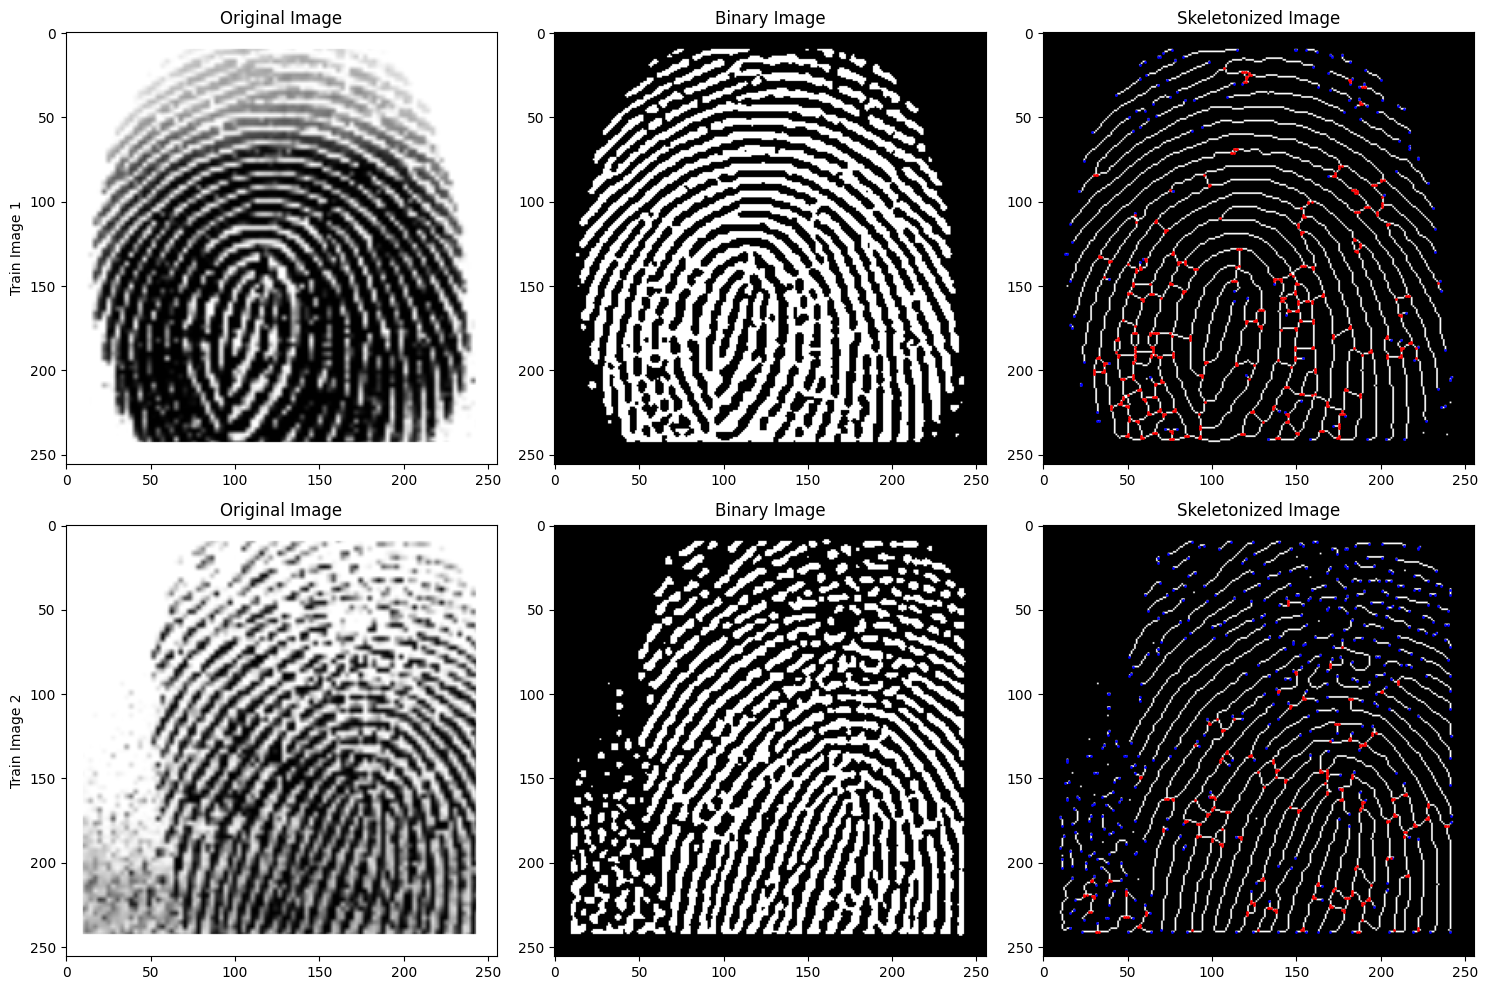

In [44]:
# 결과 확인
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    axes[i, 0].imshow(preprocessed_train_images[i][0], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 1].imshow(preprocessed_train_images[i][1], cmap='gray')
    axes[i, 1].set_title('Binary Image')
    axes[i, 2].imshow(preprocessed_train_images[i][2], cmap='gray')
    axes[i, 2].set_title('Skeletonized Image')

    # 분기점과 끝점 표시
    for y, x in train_minutiae[i][0]:
        axes[i, 2].plot(x, y, 'bo', markersize=1)  # 끝점 : 파란색
    for y, x in train_minutiae[i][1]:
        axes[i, 2].plot(x, y, 'ro', markersize=1)  # 분기점 : 빨간색

axes[0, 0].set_ylabel('Train Image 1')
axes[1, 0].set_ylabel('Train Image 2')

plt.tight_layout()
plt.show()

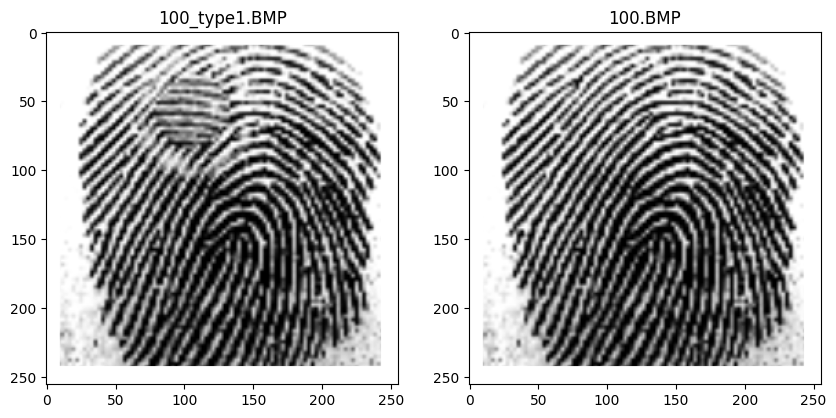

100_type1.BMP best matches with 100.BMP with average distance 1.53
100_type1.BMP matching time : 3.39s




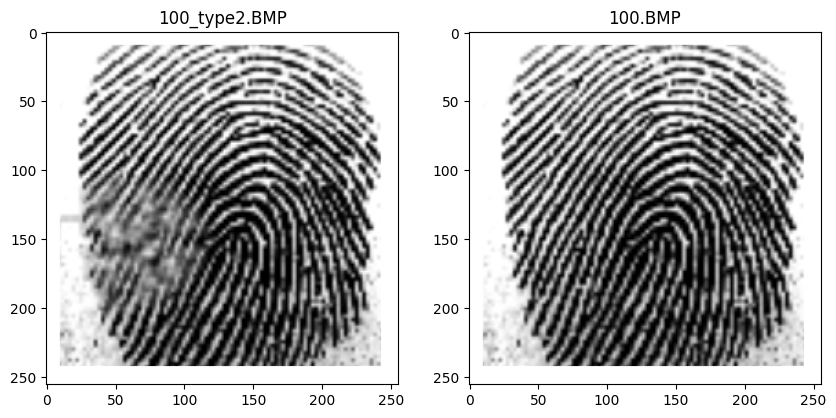

100_type2.BMP best matches with 100.BMP with average distance 1.71
100_type2.BMP matching time : 3.48s




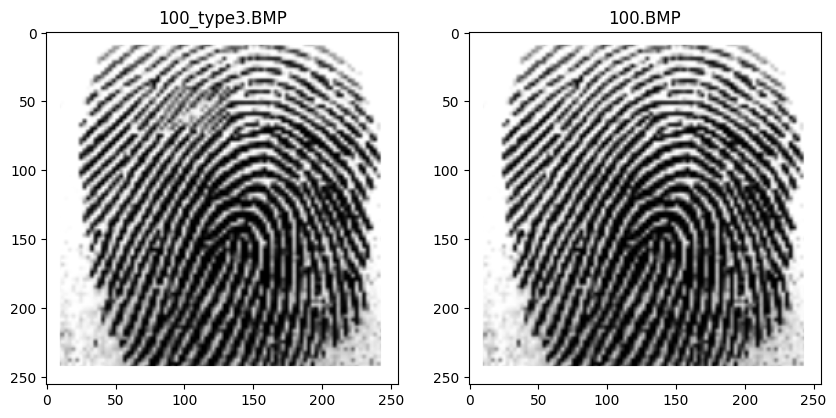

100_type3.BMP best matches with 100.BMP with average distance 0.78
100_type3.BMP matching time : 3.45s


101_type1.BMP best matches with 101.BMP with average distance 2.72
101_type1.BMP matching time : 3.08s


101_type2.BMP best matches with 101.BMP with average distance 2.27
101_type2.BMP matching time : 2.80s


101_type3.BMP best matches with 101.BMP with average distance 1.09
101_type3.BMP matching time : 2.46s


102_type1.BMP best matches with 102.BMP with average distance 0.59
102_type1.BMP matching time : 3.63s


102_type2.BMP best matches with 102.BMP with average distance 0.91
102_type2.BMP matching time : 3.65s


102_type3.BMP best matches with 102.BMP with average distance 0.35
102_type3.BMP matching time : 3.52s


104_type1.BMP best matches with 104.BMP with average distance 1.06
104_type1.BMP matching time : 2.61s


104_type2.BMP best matches with 104.BMP with average distance 1.73
104_type2.BMP matching time : 2.66s


104_type3.BMP best matches with 104.BMP with average di

In [7]:
matching_results = []

# 매칭 수행 및 결과 출력
for i, (test_end, test_bif) in enumerate(test2_minutiae):
    ##
    start_time = time.time() 

    test_image_name = basename(list_test2[i]) 
    best_match = None
    best_distance = float('inf')
    for j, (train_end, train_bif) in enumerate(train_minutiae):
        distance = match_minutiae(test_end + test_bif, train_end + train_bif)
        if distance < best_distance:
            best_distance = distance
            best_match = j

    if i in range(0, 3):  # test2의 이미지 3개만 출력하여 매칭 여부 비교
        test_image = preprocessed_test2_images[i][0]
        train_image = preprocessed_train_images[best_match][0]

        # Display the matched test and train images
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(test_image, cmap='gray')
        ax[0].set_title(f'{test_image_name}')
        ax[1].imshow(train_image, cmap='gray')
        ax[1].set_title(f'{basename(list_train[best_match])}')  
        # plt.suptitle(f'Best match distance: {best_distance}')
        plt.show()
    
    # 평균 거리 계산
    avg_distance = best_distance / (len(test_end) + len(test_bif))
    train_image_name = basename(list_train[best_match])  # 수정된 부분

    elapsed_time = time.time() - start_time
    
    
    # 각 test2 이미지에 대한 매칭 결과 저장
    matching_results.append({
        'test_image': test_image_name,
        'train_image': train_image_name,
        'average_distance': avg_distance
    })
    print(f"{test_image_name} best matches with {train_image_name} with average distance {avg_distance:.2f}")
    print(f"{test_image_name} matching time : {elapsed_time:.2f}s")
    print("\n")
    
print("Matching completed.")

In [55]:
# threshold 범위 설정
thresholds = np.arange(3.5, 4.6, 0.1)

# 각 threshold에 따른 precision과 FAR, FRR, ACC 계산
precisions = []
false_positive_rates = []
false_negative_rates = []
accuracies = []

for threshold in thresholds:
    metrics = calculate_metrics(matching_results, threshold)
    precisions.append(metrics['precision'])
    false_positive_rates.append(metrics['FAR'])
    false_negative_rates.append(metrics['FRR'])
    accuracies.append(metrics['ACC'])

# 결과 출력
for i, threshold in enumerate(thresholds):
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision: {precisions[i]:.4f}")
    print(f"FAR: {false_positive_rates[i]:.4f}")
    print(f"FRR: {false_negative_rates[i]:.4f}")
    print(f"ACC: {accuracies[i]:.4f}")
    print()


Threshold: 3.50
Precision: 0.8488
FAR: 0.8142
FRR: 0.0162
ACC: 0.8424

Threshold: 3.60
Precision: 0.8462
FAR: 0.8340
FRR: 0.0119
ACC: 0.8424

Threshold: 3.70
Precision: 0.8437
FAR: 0.8538
FRR: 0.0077
ACC: 0.8424

Threshold: 3.80
Precision: 0.8394
FAR: 0.8854
FRR: 0.0034
ACC: 0.8403

Threshold: 3.90
Precision: 0.8371
FAR: 0.9012
FRR: 0.0026
ACC: 0.8382

Threshold: 4.00
Precision: 0.8326
FAR: 0.9328
FRR: 0.0009
ACC: 0.8340

Threshold: 4.10
Precision: 0.8309
FAR: 0.9447
FRR: 0.0009
ACC: 0.8319

Threshold: 4.20
Precision: 0.8297
FAR: 0.9526
FRR: 0.0009
ACC: 0.8305

Threshold: 4.30
Precision: 0.8286
FAR: 0.9605
FRR: 0.0000
ACC: 0.8298

Threshold: 4.40
Precision: 0.8275
FAR: 0.9684
FRR: 0.0000
ACC: 0.8284

Threshold: 4.50
Precision: 0.8263
FAR: 0.9763
FRR: 0.0000
ACC: 0.8270

